# Timeseries Transformer

In [524]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/a/64438413

In [525]:
from __future__ import annotations
import glob
import inspect
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from sklearn.model_selection import ParameterGrid
import sys
import tensorflow as tf
import tensorflow.keras as keras
from typing import Callable

In [526]:
sns.set() # Use seaborn themes.

## Environment Setup

This section contains code that is modifies output path locations, random seed, and logging.

In [527]:
DATASET_ROOT = Path('~/research/makassar/datasets').expanduser()
if not DATASET_ROOT.exists(): raise ValueError(f"Dataset root directory does not exist at {DATASET_ROOT}")
PROJECT_ROOT = Path('~/research/makassar').expanduser()
CHECKPOINT_ROOT = PROJECT_ROOT / 'checkpoints'
IMAGE_ROOT = PROJECT_ROOT / 'images'
TABLE_ROOT = PROJECT_ROOT / 'tables'
HP_TUNING_ROOT = PROJECT_ROOT / 'hp_tuning'

# Ensure some directories exist.
PROJECT_ROOT.mkdir(parents=True, exist_ok=True)
CHECKPOINT_ROOT.mkdir(parents=True, exist_ok=True)
IMAGE_ROOT.mkdir(parents=True, exist_ok=True)
TABLE_ROOT.mkdir(parents=True, exist_ok=True)
HP_TUNING_ROOT.mkdir(parents=True, exist_ok=True)

In [528]:
# Set random seeds.
SEED = 0
tf.random.set_seed(SEED) # Only this works on ARC (since tensorflow==2.4).

In [529]:
# Setup logging (useful for ARC systems).
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG) # Must be lowest of all handlers listed below.
while logger.hasHandlers(): logger.removeHandler(logger.handlers[0]) # Clear all existing handlers.

# Custom log formatting.
formatter = logging.Formatter('%(asctime)s | %(levelname)s | %(message)s')

# Log to STDOUT (uses default formatting).
sh = logging.StreamHandler(stream=sys.stdout)
sh.setLevel(logging.INFO)
logger.addHandler(sh)

# Set Tensorflow logging level.
tf.get_logger().setLevel('ERROR') # 'INFO'

In [530]:
# List all GPUs visible to TensorFlow.
gpus = tf.config.list_physical_devices('GPU')
logger.info(f"Num GPUs Available: {len(gpus)}")
for gpu in gpus:
    logger.info(f"Name: {gpu.name}, Type: {gpu.device_type}")

Num GPUs Available: 1
Name: /physical_device:GPU:0, Type: GPU


## Window Subset Loader

The `WindowGenerator` class operates on `pandas.DataFrame` objects. It accomplishes several tasks:

1. Split the data into contiguous windows.
2. Convert the data into a `tensorflow.Dataset` class for batch loading.

In [531]:
# Inspiration: https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing
class WindowGenerator:
    def __init__(self,
        in_seq_len: int,
        out_seq_len: int,
        shift: int,
        columns: list[str],
        in_feat: list[str] = None,
        out_feat: list[str] = None,
        batch_size: int = 32,
        shuffle: bool = False,
        ):
        """Constructs sliding windows of sequential data.

        Args:
            in_seq_len (int): Input sequence length.
            out_seq_len (int): Output (target) sequence length.
            shift (int): Number of indices to skip between elements when traversing window.
            columns (list[str]): List of column names in dataframes.
            in_feat (list[str], optional): Desired subset of input features for window. Defaults to None.
            out_feat (list[str], optional): Desired subset of output features for window. Defaults to None.
            batch_size (int, optional): Batch size. Defaults to 32.
            shuffle (bool, optional): Shuffle windows prior to batching. Defaults to False.
        """
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Preserve sequence information.
        self.in_seq_len = in_seq_len
        self.out_seq_len = out_seq_len
        self.shift = shift
        self.total_window_len = in_seq_len + shift

        # Setup indexing slices for window extraction.
        self.in_slice = slice(0, self.in_seq_len)
        self.out_slice = slice(self.total_window_len - self.out_seq_len, None)
        self.in_idx = np.arange(self.total_window_len)[self.in_slice]
        self.out_idx = np.arange(self.total_window_len)[self.out_slice]

        # Setup train/val/test column extractors.
        self.col2idx = {name: i for i, name in enumerate(columns)}
        if in_feat is not None:
            self.in_feat = in_feat
            self.in_col_idx = [self.col2idx[col] for col in in_feat]
        else:
            self.in_feat = [columns[i] for i in self.in_col_idx]
            self.in_col_idx = list(range(len(columns)))
        if out_feat is not None:
            self.out_feat = out_feat
            self.out_col_idx = [self.col2idx[col] for col in out_feat]
        else:
            self.out_feat = [columns[i] for i in self.out_col_idx]
            self.out_col_idx = list(range(len(columns)))

    def __repr__(self):
        """String representation of class."""
        return '\n'.join([
            f"Total window length: {self.total_window_len}",
            f"Input indices: {self.in_idx}",
            f"Output indices: {self.out_idx}",
            f"Input features: {self.in_feat}",
            f"Output features: {self.out_feat}",
        ])

    def split_window(self, 
        window: tf.Tensor, # window shape is (batch, seq, feat)
        ) -> tuple[tf.Tensor, tf.Tensor]:
        """Splits a single window of data into input/output seqments.

        Args:
            window (tf.Tensor): Tensor of window data with shape (batch, seq, feat).

        Returns:
            tuple[tf.Tensor, tf.Tensor]: 2-tuple of input/output data segments, where the shapes are:
                - Input window: (batch, in_seq_len, in_feat)
                - Output window: (batch, out_seq_len, out_feat)
        """
        # Decompose input/output sequence from given input window.
        in_seq = tf.stack([window[:, self.in_slice, i] for i in self.in_col_idx], axis=-1)
        out_seq = tf.stack([window[:, self.out_slice, i] for i in self.out_col_idx], axis=-1)

        # Set shape for input/output sequences.
        # Note that dimensions set to `None` are not updated.
        in_seq = tf.ensure_shape(in_seq, (None, self.in_seq_len, None))
        out_seq = tf.ensure_shape(out_seq, (None, self.out_seq_len, None))

        return in_seq, out_seq

    def make_dataset(self, 
        df: pd.DataFrame,
        batch_size: int = None,
        shuffle: bool = None,
        ) -> tf.data.Dataset:
        """Construct a TensorFlow Dataset from given input data frame.

        Datasets load tuples of batched input/output windows with shapes:
            - Input window: (batch, in_seq_len, in_feat)
            - Output window: (batch, out_seq_len, out_feat)

        Note that output windows are generally target sequences.

        Args:
            df (pd.DataFrame): Source data frame.
            batch_size (int, optional): Batch size. Defaults to class value.
            shuffle (bool, optional): Shuffle windows prior to batching. Defaults to class value.

        Returns:
            tf.data.Dataset: Dataset object.
        """
        if batch_size is None:
            batch_size = self.batch_size
        if shuffle is None:
            shuffle = self.shuffle

        # Convert data frame into numpy matrix.
        data = df.to_numpy()

        # Convert data matrix into TensorFlow dataset.
        # dataset = keras.utils.timeseries_dataset_from_array(
        dataset = keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_len,
            sequence_stride=self.shift,
            shuffle=shuffle,
            batch_size=batch_size,
        )

        # Pipe the raw dataset into the window splitting function.
        dataset = dataset.map(self.split_window)

        # Return the dataset.
        return dataset

## Beijing PM2.5 Dataset

In [532]:
def partition_dataset_df(
    df: pd.DataFrame,
    split: tuple[float, float, float] = (0.8, 0.1, 0.1),
    ) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Split a Pandas dataframe into train, validation, and test subsets.

    Args:
        df (pd.DataFrame): Source dataframe.
        split (tuple[float, float, float], optional): Tuple of split ratios. Must sum to 1. Defaults to (0.8, 0.1, 0.1).

    Returns:
        tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]: Tuple of train, validation, and test dataframes.
    """
    assert isinstance(split, (list, tuple))
    assert len(split) == 3
    assert np.isclose(sum(split), 1.0)

    # Split dataframe into train/val/test dataframes.
    # Inspiration: https://www.tensorflow.org/tutorials/structured_data/time_series#split_the_data
    train_split, val_split, test_split = split # Unpack split tuple.
    n = len(df.index) # Total number of data records.
    df_train = df[:int(n*train_split)].copy()
    df_val = df[int(n*train_split):int(n*(1-test_split))].copy()
    df_test = df[int(n*(1-test_split)):].copy()
    return df_train, df_val, df_test

In [533]:
def load_beijingpm25_df(
    path: str = None,
    split: tuple[float, float, float] = None,
    ) -> pd.DataFrame:
    """Loads Beijing PM2.5 dataset as a pandas dataframe.

    https://archive-beta.ics.uci.edu/ml/datasets/beijing+pm2+5+data

    Dataset features:
        - `No`: (NOT USED) row number
        - `year`: year of data in this row
        - `month`: month of data in this row
        - `day`: day of data in this row
        - `hour`: hour of data in this row
        - `pm2.5`: PM2.5 concentration (ug/m^3)
        - `DEWP`: Dew Point (â„ƒ)
        - `TEMP`: Temperature (â„ƒ)
        - `PRES`: Pressure (hPa)
        - `cbwd`: (NOT USED) Combined wind direction
        - `Iws`: Cumulated wind speed (m/s)
        - `Is`: Cumulated hours of snow
        - `Ir`: Cumulated hours of rain
        - `datetime`: (NOT USED) dynamically generated datetime string
    """
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv'

    # Set path to current directory if necessary.
    if path is None:
        path = os.getcwd()

    # Convert path to `Path` object.
    if not isinstance(path, Path):
        path = Path(path)

    # Create path if necessary.
    path.mkdir(parents=True, exist_ok=True)

    # Download the dataset if necessary.
    filename = Path(url.rsplit('/', 1)[1]) # Get name of file.
    filepath = (path / filename).expanduser().resolve()
    filepath = keras.utils.get_file(
        fname=filepath,
        origin=url,
        )

    # Load as Pandas DataFrame.
    df = pd.read_csv(filepath)

    # Create single date column from independent year/month/day columns.
    df['datetime'] = pd.to_datetime(df[['year','month','day','hour']])

    # Partition dataframe into train/val/test.
    if split is not None:
        train_df, val_df, test_df = partition_dataset_df(df, split=split)
        return train_df, val_df, test_df

    # Use entire dataset.
    else:
        return df


def load_beijingpm25_ds(
    in_seq_len: int,
    out_seq_len: int,
    shift: int,
    in_feat: list[str],
    out_feat: list[str],
    path: str = None,
    split: tuple[float, float, float] = None,
    batch_size: int = 32,
    shuffle: bool = False,
    # drop_columns: list[str] = ['No', 'year', 'month', 'day', 'hour', 'datetime', 'cbwd'],
    drop_columns: list[str] = ['datetime', 'cbwd'],
    drop_nan: bool = True,
    norm: bool = True,
    ) -> tf.data.Dataset|tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:

    # Load dataframe.
    df = load_beijingpm25_df(path=path)
    if drop_columns:
        df.drop(columns=drop_columns, inplace=True)
    if drop_nan:
        df.dropna(inplace=True) # Remove NaN.

    # Build window generator.
    columns = df.columns
    wg = WindowGenerator(
        in_seq_len=in_seq_len,
        out_seq_len=out_seq_len,
        shift=shift,
        columns=columns,
        in_feat=in_feat,
        out_feat=out_feat,
        batch_size=batch_size,
        shuffle=shuffle,
    )

    # Partition dataframe into train/val/test.
    if split is not None:
        train_df, val_df, test_df = partition_dataset_df(df, split=split)

        # Reset the indices to zero.
        train_df.reset_index(inplace=True)
        val_df.reset_index(inplace=True)
        test_df.reset_index(inplace=True)

        # Normalize to 0 mean and 1 std.
        if norm:
            train_mean = train_df.mean()
            train_std = train_df.std()
            train_df = (train_df - train_mean)/train_std
            val_df = (val_df - train_mean)/train_std
            test_df = (test_df - train_mean)/train_std

        # Convert train/val/test frames into windowed datasets.
        train_ds = wg.make_dataset(train_df)
        val_ds = wg.make_dataset(val_df)
        test_ds = wg.make_dataset(test_df)

        return train_ds, val_ds, test_ds

    # Use entire dataset.
    else:

        # Normalize to 0 mean and 1 std.
        if norm:
            mean = df.mean()
            std = df.std()
            df = (df - mean)/std

        # Build dataset.
        ds = wg.make_dataset(df)

        return ds







# df = load_beijingpm25_df(
#     path=DATASET_ROOT/'beijing_pm25',
# )
# print(df.info())

# # a, b, c = partition_dataset_df(df)
# # print(a.info())
# # print(b.info())
# # print(c.info())


# in_seq_len = 30
# out_seq_len = 7
# shift = 1
# in_feat = [
#     # 'pm2.5',
#     'DEWP',
#     'TEMP',
#     'PRES',
#     'Iws',
#     'Is',
#     'Ir',
# ]
# out_feat = [
#     'pm2.5',
# ]
# train_ds, val_ds, test_ds = load_beijingpm25_ds(
#     in_seq_len=in_seq_len,
#     out_seq_len=out_seq_len,
#     shift=shift,
#     in_feat=in_feat,
#     out_feat=out_feat,
#     split=(0.8,0.1,0.1),
#     path=DATASET_ROOT/'beijing_pm25',
# )
# print(train_ds)

# logger.info(f"train: {tf.data.experimental.cardinality(train_ds)} batches")
# logger.info(f"val: {tf.data.experimental.cardinality(val_ds)} batches")
# logger.info(f"test: {tf.data.experimental.cardinality(test_ds)} batches")

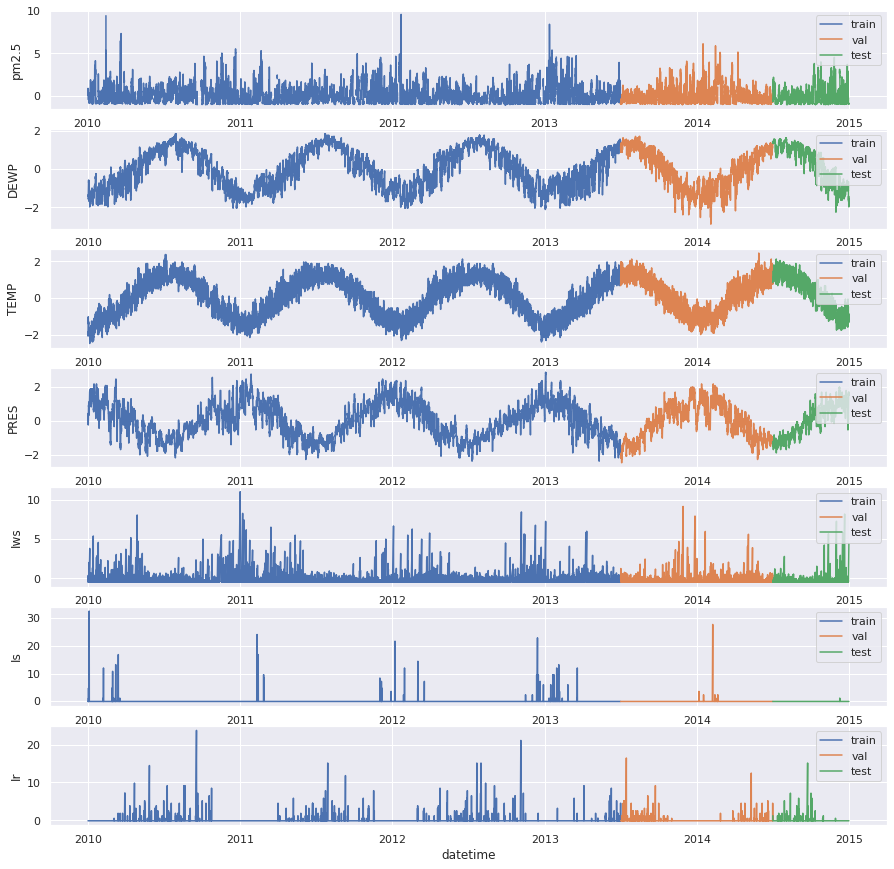

In [534]:
# Load the dataset.
train_df, val_df, test_df = load_beijingpm25_df(
    split=(0.7,0.2,0.1),
    path=DATASET_ROOT/'beijing_pm25',
)

# Data keys.
keys = [
    'pm2.5',
    'DEWP',
    'TEMP',
    'PRES',
    'Iws',
    'Is',
    'Ir',
]

# Normalize specific keys.
train_mean = train_df[keys].mean()
train_std = train_df[keys].std()
train_df[keys] = (train_df[keys] - train_mean)/train_std
val_df[keys] = (val_df[keys] - train_mean)/train_std
test_df[keys] = (test_df[keys] - train_mean)/train_std

# Plot data keys.
fig, axs = plt.subplots(nrows=len(keys), figsize=(15,15))
for i,key in enumerate(keys):
    sns.lineplot(data=train_df, x='datetime', y=key, label='train', ax=axs[i])
    sns.lineplot(data=val_df, x='datetime', y=key, label='val', ax=axs[i])
    sns.lineplot(data=test_df, x='datetime', y=key, label='test', ax=axs[i])
    axs[i].legend(loc='upper right')

## Multi-feature Time2Vec Embedding

Here I build a variation of the `Time2Vec` embedding scheme, originally defined in <https://arxiv.org/abs/1907.05321>, which supports multi-feature input.

In [535]:
class Time2Vec(keras.layers.Layer):
    def __init__(self, embed_dim: int, activation: str = 'sin', **kwargs):
        """Vector embedding representation of time.

        Based on the original concept proposed by Kazemi et al., 2019 (https://arxiv.org/abs/1907.05321).

        This layer operates on a single time step with N feature dimensions. When using this layer for multi-time-step
        datasets, you must pass this layer through a `keras.layers.TimeDistributed` layer to multiplex this for all time steps.

        Note that embedding is done on a per-feature basis. For example, using an input record with 7 features (i.e., shape=(1, 7))
        and an embeddding dimension of 10, the resulting embedding would have 70 dimensions (i.e., shape=(1, 70)). This is because
        each of the 7 features gets a 10-dimensional embedding.

        Args:
            embed_dim (int): Length of the time embedding vector.
            activation (str, optional): Periodic activation function. Possible values are ['sin', 'cos']. Defaults to 'sin'.
        """
        super().__init__(**kwargs)
        self.embed_dim = embed_dim # Embed dimension is k+1.
        self.activation = activation.lower() # Convert to lower-case.

        # Set periodic activation function.
        if self.activation.startswith('sin'):
            self.activation_func = tf.sin
        elif self.activation.startswith('cos'):
            self.activation_func = tf.cos
        else:
            raise ValueError(f'Unsupported periodic activation function "{activation}"')

    def build(self, input_shape: list[int]):

        # Weight and bias term for linear portion (i = 0)
        # of embedding.
        self.w_linear = self.add_weight(
            name='w_linear',
            shape=(input_shape[1],),
            initializer='uniform',
            trainable=True,
        )
        self.b_linear = self.add_weight(
            name='b_linear',
            shape=(input_shape[1],),
            initializer='uniform',
            trainable=True,
        )

        # Weight and bias terms for the periodic
        # portion (1 <= i <= k) of embedding.
        self.w_periodic = self.add_weight(
            name='w_periodic',
            shape=(1, input_shape[1], self.embed_dim-1,),
            initializer='uniform',
            trainable=True,
        )
        self.b_periodic = self.add_weight(
            name='b_periodic',
            shape=(1, input_shape[1], self.embed_dim-1,),
            initializer='uniform',
            trainable=True,
        )

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """Embed input into linear and periodic feature components.

        Args:
            x (tf.Tensor): Input tensor with shape (sequence_length, feature_size)

        Returns:
            tf.Tensor: Output tensor with shape (sequence_length, feature_size * embed_dim)
        """
        # Linear term (i = 0).
        embed_linear = self.w_linear * x + self.b_linear
        embed_linear = tf.expand_dims(embed_linear, axis=-1) # Reshape to (sequence_length, feature_size, 1)

        # Periodic terms (1 <= i <= k).
        inner = keras.backend.dot(x, self.w_periodic) + self.b_periodic
        embed_periodic = self.activation_func(inner) # (sequence_length, feature_size, embed_dim - 1)

        # Return concatenated linear and periodic features.
        ret = tf.concat([embed_linear, embed_periodic], axis=-1) # (sequence_length, feature_size, embed_dim)
        ret = tf.reshape(ret, (-1, x.shape[1]*self.embed_dim)) # (sequence_length, feature_size * embed_dim)
        return ret

    def compute_output_shape(self, input_shape: tf.TensorShape) -> tf.TensorShape:
        """Determines the output shape for a given input shape.

        Args:
            input_shape (tf.TensorShape): Input shape (sequence_length, feature_size).

        Returns:
            tf.TensorShape: Output shape (sequence_length, feature_size * embed_dim).
        """
        return tf.TensorShape((input_shape[0], input_shape[1]*self.embed_dim))

    def get_config(self) -> dict:
        """Retreive custom layer configuration for future loading.

        Returns:
            dict: Configuration dictionary.
        """
        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'activation': self.activation,
        })
        return config


# Update custom objects dictionary.
keras.utils.get_custom_objects()['Time2Vec'] = Time2Vec



# stock_feat = 7
# seq_len = 128
# embed_dim = 10
# inp = keras.Input(shape=(seq_len, stock_feat))
# logger.info(f"{inp.shape=}")
# x = keras.layers.TimeDistributed(Time2Vec(embed_dim))(inp)
# logger.info(f"{x.shape=}")
# x = keras.layers.Concatenate(axis=-1)([inp, x])
# logger.info(f"{x.shape=}")

## Transformer Architecture

In this section, I build a pure-encoder Transformer for time-series regression, based on the original full Transformer architecture defined in <https://arxiv.org/abs/1706.03762>. The model uses the multi-feature `Time2Vec` layer defined above.

### Attention Layers

This implementation currently uses attention layers provided by TensorFlow. See https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention.

### Point-wise Feed Forward Network

https://www.tensorflow.org/text/tutorials/transformer#point_wise_feed_forward_network

In [536]:
class PointWiseFeedForwardLayer(keras.layers.Layer):
    def __init__(self, dims: list[int], activation: str = 'gelu', **kwargs):
        """Generic point-wise feed forward layer subnetwork.

        Args:
            dims (list[int]): List of dense layer dimensions. The length of the list determines the number of dimensions. Must be at least 2 dimensions given.
            activation (str, optional): Activation function to use for the first `N-1` dense layers. The final layer has no activation.
        """
        super().__init__(**kwargs)
        assert len(dims) > 1 # Must provide at least 2 dimensions.
        self.dims = dims
        self.n_dim = len(self.dims)
        self.activation = activation

    def build(self, input_shape):
        self.ff_layers = []
        for i, dim in enumerate(self.dims):
            if i < self.n_dim-1:
                self.ff_layers.append(keras.layers.Dense(dim, activation=self.activation))
            else:
                self.ff_layers.append(keras.layers.Dense(dim))

    def call(self, x):
        for i in range(self.n_dim):
            x = self.ff_layers[i](x)
        return x

    def get_config(self) -> dict:
        """Retreive custom layer configuration for future loading.

        Returns:
            dict: Configuration dictionary.
        """
        config = super().get_config().copy()
        config.update({
            'dims': self.dims,
            'activation': self.activation,
        })
        return config

# Update custom objects dictionary.
keras.utils.get_custom_objects()['PointWiseFeedForwardLayer'] = PointWiseFeedForwardLayer

### Transformer Encoder Layer

https://www.tensorflow.org/text/tutorials/transformer#encoder_layer

In [537]:
class TransformerEncoderLayer(keras.layers.Layer):
    def __init__(self,
        model_dim: int,
        n_heads: int,
        key_dim: int = None,
        value_dim: int = None,
        ff_dim: int = 2048,
        dropout: float = 0.0,
        **kwargs,
        ):
        """Transformer encoder layer.

        Based on the original concept proposed by Vaswani et al., 2017 (https://arxiv.org/abs/1706.03762).

        Args:
            model_dim (int): Encoder input and output feature dimensions.
            n_heads (int): Number of attention heads.
            key_dim (int, optional): Key dimension. If `None` is specified then defaults to `int(model_dim/n_heads)`. Defaults to `None`.
            value_dim (int, optional): Value dimension. If None is specified the Key dimension will be used. Defaults to `None`.
            ff_dim (int, optional): Dimension of the feed forward sublayer. Defaults to `2048`.
            dropout (float, optional): Dropout rate. Defaults to `0.0`.
        """
        super().__init__(**kwargs)
        self.model_dim = model_dim
        self.n_heads = n_heads # Number of attention heads.
        if key_dim is None:
            self.key_dim = max(int(model_dim/n_heads), 1)
        else:
            self.key_dim = key_dim
        if value_dim is None:
            self.value_dim = max(int(model_dim/n_heads), 1)
        else:
            self.value_dim = value_dim
        self.ff_dim = ff_dim
        self.dropout = dropout

    def build(self, input_shape: tf.TensorShape):

        # First sublayer.
        # Multi-head attention with add and norm.
        self.attn_multi = keras.layers.MultiHeadAttention(
            num_heads=self.n_heads,
            key_dim=self.key_dim,
            value_dim=self.value_dim,
            output_shape=self.model_dim,
        )
        self.attn_multi._build_from_signature(input_shape, input_shape, input_shape)
        self.attn_dropout = keras.layers.Dropout(rate=self.dropout)
        self.attn_add = keras.layers.Add()
        # self.attn_norm = keras.layers.LayerNormalization(epsilon=1e-6)
        self.attn_norm = keras.layers.BatchNormalization()

        # Second sublayer.
        # Point-wise feed forward network with add and norm.
        # d_query_feat = input_shape[0][-1] # Query feature size.
        self.ff_net = PointWiseFeedForwardLayer(
            dims=[self.ff_dim, self.model_dim],
            activation='gelu',
        )
        self.ff_dropout = keras.layers.Dropout(rate=self.dropout)
        self.ff_add = keras.layers.Add()
        # self.ff_norm = keras.layers.LayerNormalization(epsilon=1e-6)
        self.ff_norm = keras.layers.BatchNormalization()

    def call(self, 
        x: tf.Tensor,
        training: bool = False,
        ) -> tf.Tensor:
        """Encode input using multi-head self-attention mechanisms.

        Args:
            x (tf.Tensor): Batched input sequence into the encoder layer with shape `(batch_size, sequence_length, model_dim)`.
            training (bool, optional): Indicates whether the `call` is meant for training or inference. Defaults to `False`.

        Returns:
            tf.Tensor: Output tensor with shape (batch_size, sequence_length, model_dim)
        """
        # First, do the attention sublayer.
        x_attn = self.attn_multi(x, x, x) # Unpack input as Query, Value, and optional Key.
        x_attn = self.attn_dropout(x_attn, training=training)
        x_attn = self.attn_add([x, x_attn]) # (residual) Add Query matrix with result of attention layer.
        x_attn = self.attn_norm(x_attn, training=training) # Normalize the residual.

        # Second, do the feed forward sublayer.
        x_ff = self.ff_net(x_attn)
        x_ff = self.ff_dropout(x_ff, training=training)
        x_ff = self.ff_add([x_attn, x_ff])
        x_ff = self.ff_norm(x_ff, training=training)

        # Return output of feed forward sublayer.
        return x_ff

    def get_config(self) -> dict:
        """Retreive custom layer configuration for future loading.

        Returns:
            dict: Configuration dictionary.
        """
        config = super().get_config().copy()
        config.update({
            'model_dim': self.model_dim,
            'n_heads': self.n_heads,
            'key_dim': self.key_dim,
            'ff_dim': self.ff_dim,
            'value_dim': self.value_dim,
            'dropout': self.dropout,
        })
        return config

# Update custom objects dictionary.
keras.utils.get_custom_objects()['TransformerEncoderLayer'] = TransformerEncoderLayer

### Transformer Decoder Layer

https://www.tensorflow.org/text/tutorials/transformer#decoder_layer

In [538]:
class TransformerDecoderLayer(keras.layers.Layer):
    def __init__(self,
        model_dim: int,
        n_heads: int,
        key_dim: int = None,
        value_dim: int = None,
        ff_dim: int = 2048,
        dropout: float = 0.0,
        **kwargs,
        ):
        """Transformer decoder layer.

        Based on the original concept proposed by Vaswani et al., 2017 (https://arxiv.org/abs/1706.03762).

        Args:
            model_dim (int): Decoder input and output feature dimensions.
            n_heads (int): Number of attention heads.
            key_dim (int, optional): Key dimension. If `None` is specified then defaults to `int(model_dim/n_heads)`. Defaults to `None`.
            value_dim (int, optional): Value dimension. If None is specified the Key dimension will be used. Defaults to `None`.
            ff_dim (int, optional): Dimension of the feed forward sublayer. Defaults to `2048`.
            dropout (float, optional): Dropout rate. Defaults to `0.0`.
        """
        super().__init__(**kwargs)
        self.model_dim = model_dim
        self.n_heads = n_heads # Number of attention heads.
        if key_dim is None:
            self.key_dim = max(int(model_dim/n_heads), 1)
        else:
            self.key_dim = key_dim
        if value_dim is None:
            self.value_dim = max(int(model_dim/n_heads), 1)
        else:
            self.value_dim = value_dim
        self.ff_dim = ff_dim
        self.dropout = dropout

    def build(self, input_shape: tuple[tf.TensorShape,tf.TensorShape]):
        print(f"{input_shape}")
        assert len(input_shape) == 2

        #### First sublayer ####
        # Masked multi-head self-attention with add and norm.
        self.l1_attn_multi = keras.layers.MultiHeadAttention(
            num_heads=self.n_heads,
            key_dim=self.key_dim,
            value_dim=self.value_dim,
            output_shape=self.model_dim,
        )
        # self.l1_attn_multi._build_from_signature(input_shape[0], input_shape[0], input_shape[0])
        self.l1_dropout = keras.layers.Dropout(rate=self.dropout)
        self.l1_add = keras.layers.Add()
        # self.l1_norm = keras.layers.LayerNormalization(epsilon=1e-6)
        self.l1_norm = keras.layers.BatchNormalization()

        #### Second sublayer ####
        # Multi-head attention with add and norm.
        self.l2_attn_multi = keras.layers.MultiHeadAttention(
            num_heads=self.n_heads,
            key_dim=self.key_dim,
            value_dim=self.value_dim,
            output_shape=self.model_dim,
        )
        # self.l2_attn_multi._build_from_signature(input_shape[-1], input_shape[-1], self.l1_attn_multi.shape)
        self.l2_dropout = keras.layers.Dropout(rate=self.dropout)
        self.l2_add = keras.layers.Add()
        # self.l2_norm = keras.layers.LayerNormalization(epsilon=1e-6)
        self.l2_norm = keras.layers.BatchNormalization()

        #### Third sublayer ####
        # Point-wise feed forward network with add and norm.
        # d_query_feat = input_shape[0][-1] # Query feature size.
        self.l3_ff = PointWiseFeedForwardLayer(
            dims=[self.ff_dim, self.model_dim],
            activation='gelu',
        )
        self.l3_dropout = keras.layers.Dropout(rate=self.dropout)
        self.l3_add = keras.layers.Add()
        # self.l3_norm = keras.layers.LayerNormalization(epsilon=1e-6)
        self.l3_norm = keras.layers.BatchNormalization()

    def call(self,
        x: tuple[tf.Tensor, tf.Tensor],
        look_ahead_mask: tf.Tensor = None,
        memory_mask: tf.Tensor = None,
        training: bool = False,
        return_attention_scores: bool = False,
        ) -> tf.Tensor|tuple[tf.Tensor,tuple[tf.Tensor,tf.Tensor]]:
        """Decode input using multi-head attention.

        Accepts decoder input sequence `x` and `memory` sequence 
        (often the output of the last encoder layer).

        Args:
            x (tuple[tf.Tensor, tf.Tensor]): List of batched decoder input sequence, and batched memory sequence (often the output of the last encoder layer).
            look_ahead_mask (tf.Tensor, optional): Attention mask for the decoder input sequence. Defaults to `None`.
            memory_mask (tf.Tensor, optional): Attention mask for the memory sequence. Defaults to `None`.
            training (bool, optional): Indicates whether the `call` is meant for training or inference. Defaults to `False`.
            return_attention_scores (bool, optional): Indicates whether the output is `(attention_output, attention_scores)` if `True`, or `attention_output` if `False`. Defaults to `False`.

        Returns:
            tf.Tensor|tuple[tf.Tensor,tuple[tf.Tensor,tf.Tensor]]: Output depends on `return_attention_scores` value.  Returns `(attention_output, attention_scores)` if `return_attention_scores=True`, or `attention_output` if `return_attention_scores=False`.
        """
        # Unpack target and memory from input list.
        target, memory = x

        # Self-attention input layer.
        x_l1_attn, x_l1_attn_weights = self.l1_attn_multi(
            target, target, target,
            attention_mask=look_ahead_mask,
            return_attention_scores=True,
        )
        x_l1_attn = self.l1_dropout(x_l1_attn, training=True)
        out_l1 = self.l1_add([x_l1_attn, target])
        out_l1 = self.l1_norm(out_l1, training=training)

        logger.info(f"{out_l1.shape=}")

        # Second attention layer with previous encoder input.
        x_l2_attn, x_l2_attn_weights = self.l2_attn_multi(
            memory, memory, out_l1,
            attention_mask=memory_mask,
            return_attention_scores=True,
        )
        x_l2_attn = self.l2_dropout(x_l2_attn, training=training)
        logger.info(f"{x_l2_attn.shape=}")
        out_l2 = self.l2_add([x_l2_attn, out_l1])
        out_l2 = self.l2_norm(out_l2, training=training)

        # Third layer with point-wise feed forward network.
        x_l3 = self.l3_ff(out_l2)
        x_l3 = self.l3_dropout(x_l3, training=training)
        out_l3 = self.l3_add([x_l3, out_l2])
        out_l3 = self.l3_norm(out_l3, training=training)

        # Return attention scores.
        if return_attention_scores:
            return out_l3, (x_l1_attn_weights, x_l2_attn_weights)
        # Return final layer output.
        else:
            return out_l3

    def get_config(self) -> dict:
        """Retreive custom layer configuration for future loading.

        Returns:
            dict: Configuration dictionary.
        """
        config = super().get_config().copy()
        config.update({
            'model_dim': self.model_dim,
            'n_heads': self.n_heads,
            'key_dim': self.key_dim,
            'ff_dim': self.ff_dim,
            'value_dim': self.value_dim,
            'dropout': self.dropout,
        })
        return config

# Update custom objects dictionary.
keras.utils.get_custom_objects()['TransformerDecoderLayer'] = TransformerDecoderLayer


seq_len = 30
in_feat = 5
embed_dim = 4
inp = keras.Input(shape=(seq_len, in_feat))
logger.info(f"{inp.shape=}")
x = keras.layers.TimeDistributed(Time2Vec(embed_dim))(inp)
logger.info(f"Time2Vec {x.shape=}")
x = keras.layers.Concatenate(axis=-1)([inp, x])


model_dim = x.shape[-1]
n_heads = 8
key_dim = int(model_dim/n_heads)
value_dim = int(model_dim/n_heads)
ff_dim = 2048
logger.info(f"{model_dim=}")
logger.info(f"{n_heads=}")
logger.info(f"{key_dim=}")
logger.info(f"{value_dim=}")
logger.info(f"{ff_dim=}")

decoder_inp = keras.Input(shape=(seq_len, in_feat))
logger.info(f"{decoder_inp.shape=}")
decoder_inp_embed = keras.layers.TimeDistributed(Time2Vec(embed_dim))(decoder_inp)
logger.info(f"Time2Vec {decoder_inp.shape=}")
decoder_inp = keras.layers.Concatenate(axis=-1)([decoder_inp, decoder_inp_embed])
logger.info(f"Concatenate {decoder_inp.shape=}")


x = TransformerEncoderLayer(model_dim=model_dim, key_dim=key_dim, value_dim=value_dim, n_heads=n_heads, ff_dim=ff_dim)(x)
logger.info(f"TransformerEncoderLayer {x.shape=}")
x = TransformerDecoderLayer(model_dim=model_dim, key_dim=key_dim, value_dim=value_dim, n_heads=n_heads, ff_dim=ff_dim)([decoder_inp, x])
logger.info(f"TransformerDecoderLayer {x.shape=}")
x = keras.layers.GlobalAvgPool1D(data_format='channels_first')(x)
logger.info(f"GlobalAvgPool1D {x.shape=}")

inp.shape=TensorShape([None, 30, 5])
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Time2Vec x.shape=TensorShape([None, 30, 20])
model_dim=25
n_heads=8
key_dim=3
value_dim=3
ff_dim=2048
decoder_inp.shape=TensorShape([None, 30, 5])
Time2Vec decoder_inp.shape=TensorShape([None, 30, 5])
Concatenate decoder_inp.shape=TensorShape([None, 30, 25])
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
TransformerEncoderLayer x.shape=TensorShape([None, 30, 25])
[TensorShape([None, 30, 25]), TensorShape([N

### Model Definition

Here I define a function which builds the entire Transformer using the custom layers defined above.

In [539]:
def build_transformer_encoder_net(
    in_seq_len: int,
    in_feat: int,
    out_feat: int,
    fc_units: list[int], # list of fully-connected dimensions before classifier.
    embed_dim: int,
    n_heads: int,
    key_dim: int = None,
    value_dim: int = None,
    ff_dim: int = 2048,
    dropout: float = 0.0,
    n_encoders: int = 3,
    ):

    # Input sequence of features.
    inp = keras.Input(shape=(in_seq_len, in_feat))
    # Time embedding.
    x = keras.layers.TimeDistributed(Time2Vec(embed_dim))(inp)
    # Combine input with embedding to form attention input features.
    x = keras.layers.Concatenate(axis=-1)([inp, x])
    # Set model dimension, since Time2Vec embedding is dynamic.
    model_dim: int = x.shape[-1]
    # Pass combined featured through cascaded self-attention encoder sublayers.
    for _ in range(n_encoders):
        x = TransformerEncoderLayer(
            model_dim=model_dim,
            key_dim=key_dim,
            n_heads=n_heads,
            ff_dim=ff_dim,
            value_dim=value_dim,
            dropout=dropout,
        )(x)
    # Downsample to the original sequence dimension.
    x = keras.layers.GlobalAvgPool1D(data_format='channels_first')(x) # shape=(in_seq_len,)
    x = keras.layers.Dropout(rate=dropout)(x)
    # Fully-connected network before classifier.
    for units in fc_units: 
        x = keras.layers.Dense(units=units, activation='relu')(x)
        x = keras.layers.Dropout(rate=dropout)(x)
    # Classifier.
    x = keras.layers.Dense(units=out_feat, activation='linear')(x)

    # Construct model class and return.
    return keras.Model(inputs=inp, outputs=x)

## Generalized Model Training and Evaluation

In [540]:
def plot_input_output(
    df: pd.DataFrame,
    pred: tf.Tensor,
    in_seq_len: int,
    out_seq_len: int,
    shift: int,
    in_feat: list[str],
    out_feat: list[str],
    x_key: str,
    figsize: tuple = (15,7),
    width_ratios: list = [1, 1.75],
    wspace: float = 0.07,
    xtick_rotation: float = 45,
    ) -> plt.Figure:
    """Creates figure for input/output feature data."""
    fig = plt.figure(constrained_layout=True, figsize=figsize)
    subfigs = fig.subfigures(nrows=1, ncols=2, wspace=wspace, width_ratios=width_ratios)

    # Plot all input features.
    subfigs[0].suptitle('Input Features', fontsize='x-large')
    axs = subfigs[0].subplots(nrows=len(in_feat), ncols=1, sharex=True, squeeze=False)
    for r, key in enumerate(in_feat):
        sns.lineplot(
            data=df,
            x=x_key,
            y=key,
            ax=axs[r,0],
        )
    plt.xticks(rotation=xtick_rotation)

    # Plot all output features against truth.
    subfigs[1].suptitle('Output Features', fontsize='x-large')
    axs = subfigs[1].subplots(nrows=len(out_feat), ncols=1, sharex=True, squeeze=False)
    for r, key in enumerate(out_feat):
        sns.lineplot(
            data=df,
            x=x_key,
            y=key,
            ax=axs[r,0],
            label='truth',
        )
        axs[r,0].plot(
            df.iloc[
                np.arange(
                    start=in_seq_len,
                    stop=pred.shape[0]+in_seq_len,
                    step=shift,
                )
            ][x_key],
            pred[:,r],
            linewidth=3,
            label=f'forecast',
        )
        axs[r,0].legend(loc='upper right')
    plt.xticks(rotation=xtick_rotation)

    return fig


def plot_predictions(
    model: keras.models.Model,
    in_seq_len: int,
    out_seq_len: int,
    shift: int,
    split: tuple[float, float, float],
    in_feat: list[str],
    out_feat: list[str],
    batch_size: int = 64,
    shuffle: bool = True,
    strategy: tf.distribute.Strategy = tf.distribute.get_strategy(),
    ) -> dict[str, plt.Figure]:
    """Plots forecast for input/output feature set."""

    # Load on device.
    with strategy.scope():

        # Load the data in dataframe form.
        df_train, df_val, df_test = load_beijingpm25_df(
            split=split,
            path=DATASET_ROOT/'beijing_pm25',
        )

        # Load the data in dataset form.
        dataset_train, dataset_val, dataset_test = load_beijingpm25_ds(
            in_seq_len=in_seq_len,
            out_seq_len=out_seq_len,
            shift=shift,
            in_feat=in_feat,
            out_feat=out_feat,
            split=split,
            shuffle=shuffle,
            path=DATASET_ROOT/'beijing_pm25',
            batch_size=batch_size,
        )

        # Data keys.
        keys = [
            'pm2.5',
            'DEWP',
            'TEMP',
            'PRES',
            'Iws',
            'Is',
            'Ir',
        ]

        # Normalize specific keys.
        train_mean = df_train[keys].mean()
        train_std = df_train[keys].std()
        df_train[keys] = (df_train[keys] - train_mean)/train_std
        df_val[keys] = (df_val[keys] - train_mean)/train_std
        df_test[keys] = (df_test[keys] - train_mean)/train_std

        # Evaluate the model on the train/val/test data.
        train_pred = model.predict(dataset_train)
        val_pred = model.predict(dataset_val)
        test_pred = model.predict(dataset_test)


    # Create figure for each data set.
    figs = {}
    labels = ['train', 'val', 'test']
    for l, label in enumerate(labels):
        fig = plot_input_output(
            df=locals()[f"df_{label}"],
            pred=locals()[f"{label}_pred"],
            in_seq_len=in_seq_len,
            out_seq_len=out_seq_len,
            shift=shift,
            in_feat=in_feat,
            out_feat=out_feat,
            x_key='datetime',
        )
        # fig.suptitle(f"{label[0].upper()}{label[1:]} Data", fontsize='xx-large')
        figs[label] = fig

    # Return figures.
    return figs

In [541]:
def train_evaluate_model(
    model,
    datagen_train: tf.data.Dataset,
    datagen_val: tf.data.Dataset,
    datagen_test: tf.data.Dataset,
    epochs: int,
    metric_list: list[str],
    checkpoint_path: str,
    history_path: str = None,
    metrics_path: str = None,
    ) -> tuple[keras.models.Model, dict, dict]:
    """Trains and evaluates a given model on the given datasets.

    Args:
        model (_type_): The model to train and evaluation.
        datagen_train (tf.data.Dataset): Training dataset.
        datagen_val (tf.data.Dataset): Validation dataset.
        datagen_test (tf.data.Dataset): Testing dataset.
        epochs (int): Number of training epochs.
        checkpoint_path (str): Path to checkpoint file
        history_path (str, optional): Path to history CSV file. If None is provided, then the file will be located at the same path as the checkpoint file with name `"history.csv"`. Defaults to None.
        metrics_path (str, optional): Path to metrics JSON file. If None is provided, then the file will be located at the same path as the checkpoint file with name `"metrics.json"`. Defaults to None.

    Returns:
        tuple[keras.models.Model, dict, dict: Tuple of trained model, history dictionary, and metrics dictionary.
    """

    # Ensure checkpoint root directory has been created.
    checkpoint_path.parent.mkdir(parents=True, exist_ok=True)
    if history_path is None:
        history_path = checkpoint_path.parent/'history.csv'
    if metrics_path is None:
        metrics_path = checkpoint_path.parent/'metrics.json'

    # List of callbacks during training.
    callbacks = [
        # Save model checkpoint after every epoch.
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            monitor='val_loss',
            mode='min',
            save_best_only=True,
            verbose=1,
        ),
        # Log training history to CSV file.
        keras.callbacks.CSVLogger(
            filename=history_path,
            append=False,
        ),
        # Early stopping when performance does not improve across N epochs.
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            mode='auto',
            patience=10,
            # min_delta=0.001,
            restore_best_weights=True,
        ),
    ]

    # Train the model.
    history = model.fit(datagen_train,
        validation_data=datagen_val,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1,
    )

    # Evaluate the newly trained model.
    test_metrics = model.evaluate(datagen_test)

    # Create dictionary of metrics to return and preserve in file.
    metrics = {}
    for i, key in enumerate(metric_list):
        metrics[key] = history.history[key][-1]
        metrics[f"val_{key}"] = history.history[f"val_{key}"][-1]
        metrics[f"test_{key}"] = test_metrics[i+1]
    metrics['loss'] = history.history['loss'][-1]
    metrics['val_loss'] = history.history['val_loss'][-1]
    metrics['test_loss'] = test_metrics[0]

    # Dump metrics to JSON file.
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f)

    return model, history.history, metrics

In [542]:
def train_evaluate_for_dataset(
    model_name: str,
    build_model_func,
    params: dict,
    compile_params: dict,
    in_seq_len: int,
    out_seq_len: int,
    shift: int,
    split: tuple[float, float, float],
    in_feat: list[str],
    out_feat: list[str],
    batch_size: int = 128,
    shuffle: bool = False,
    strategy: tf.distribute.Strategy = tf.distribute.get_strategy(),
    epochs: int = 10,
    table_header: list = None,
    table_omit_cols: str|list[str] = None,
    ) -> tuple[keras.models.Model, dict, dict, dict, pd.DataFrame]:
    """Train and evaluate a model on a given dataset.

    If checkpoint exists then the model is loaded in place of training.
    """

    # Train and evaluate model.
    checkpoint_path = CHECKPOINT_ROOT/model_name/'model.h5'
    history_path = checkpoint_path.parent/'history.csv'
    metrics_path = checkpoint_path.parent/'metrics.json'

    # Maximize batch size efficiency using distributed strategy.
    batch_size_per_replica = batch_size
    batch_size = batch_size_per_replica * strategy.num_replicas_in_sync

    # Load data.
    with strategy.scope():

        # Load the dataset.
        dataset_train, dataset_val, dataset_test = load_beijingpm25_ds(
            in_seq_len=in_seq_len,
            out_seq_len=out_seq_len,
            shift=shift,
            in_feat=in_feat,
            out_feat=out_feat,
            split=split,
            shuffle=shuffle,
            path=DATASET_ROOT/'beijing_pm25',
            batch_size=batch_size,
        )

    # Setup model hyperparameters.
    hparams = dict(
        in_seq_len=in_seq_len,
        in_feat=len(in_feat), # Number of input features.
        out_feat=len(out_feat), # Number of output features.
        **params,
    )

    # Load model from best checkpoint.
    if checkpoint_path.exists() and history_path.exists() and metrics_path.exists():
        # Load the model.
        logger.info(f"[{model_name}] Loading best model from: {checkpoint_path}")
        with strategy.scope():
            model = keras.models.load_model(checkpoint_path, custom_objects=keras.utils.get_custom_objects())

        # Load history and metrics.
        logger.info(f"[{model_name}] Loading from save data")
        hist = load_history(history_path)
        met = load_metrics(metrics_path)

    # Train model.
    else:

        logger.info(f"[{model_name}] Training new model: {epochs=}, {batch_size=}, {strategy=}")

        # Train new model.
        with strategy.scope():

            # Create and compile model.
            model = build_model_func(
                hparams=hparams,
                compile_params=compile_params,
            )

        # Train the model using the strategy.
        model, hist, met = train_evaluate_model(
            model,
            datagen_train=dataset_train,
            datagen_val=dataset_val,
            datagen_test=dataset_test,
            epochs=epochs,
            metric_list=compile_params['metrics'],
            checkpoint_path=checkpoint_path,
            history_path=history_path,
            metrics_path=metrics_path,
        )

    # Plot the model predictions of the dataset.
    figs: dict = plot_predictions(
        model=model,
        in_seq_len=in_seq_len,
        out_seq_len=out_seq_len,
        shift=shift,
        split=split,
        in_feat=in_feat,
        out_feat=out_feat,
        batch_size=batch_size,
        shuffle=shuffle,
        strategy=strategy,
    )
    for name, fig in figs.items():
        fig.savefig(IMAGE_ROOT/f"{model_name}_io_{name}.png", bbox_inches='tight')
        fig.show()

    # Print model summary.
    logger.info(f"[{model_name}] Model Summary:")
    model.summary(print_fn=logger.info)

    logger.info(f"[{model_name}] Training and Evaluation Results:")

    # Build dataframe using results.
    df = pd.DataFrame([{
        'model': model_name,
        **met,
        **params,
    }])
    if table_header is not None:
        df = df[table_header]
    df = df.drop(columns=table_omit_cols, errors='ignore')
    logger.info(df.to_string(index=False)) # Log to console.

    # Export the dataframe to LaTeX using custom style.
    df = df.drop(columns=table_omit_cols, errors='ignore')
    df.columns = df.columns.map(lambda x: x.replace('_', '\_')) # Escape the header names too.
    styler = df.style
    styler = styler.format(str, escape='latex') # Default is to convert all cells to their string representation.
    subset = []
    for m in compile_params['metrics']+['loss']:
        if m in set(df.columns):
            subset.append(f"{m}")
            subset.append(f"val\_{m}")
            subset.append(f"test\_{m}")
    styler = styler.format(formatter='{:.4f}', subset=subset)
    styler = styler.highlight_min(subset=subset, axis=0, props='textbf:--rwrap;')
    styler = styler.hide(axis=0) # Hide the index.
    styler.to_latex(
        buf=TABLE_ROOT/f"{model_name}_results.tex",
        hrules=True,
    )
    df.columns = df.columns.map(lambda x: x.replace('\_', '_')) # Convert header names back.

    # Plot train/val performance.
    for key in compile_params['metrics']+['loss']:
        fig = plot_metric(hist, key)
        fig.savefig(IMAGE_ROOT/f"{model_name}_{key}.png", bbox_inches='tight')
        fig.show()

    return model, hist, met, params, df

In [543]:
def build_model_from_hparams(func):
    """Generalized model build and compile from hyperparameters."""
    def wrapper(hparams: dict, compile_params: dict):
        """Builds model using given hyperparameters for both model and optimizer, and compile parameters for compilation."""
        # Extract paramters needed for the model.
        model_params = {k: hparams[k] for k in inspect.signature(func).parameters if k in hparams}
        # Build model.
        model = func(**model_params)
        # Configure optimizer.
        optim = keras.optimizers.get({
            'class_name': hparams['optim'],
            'config': {
                'lr': hparams['lr'],
            },
        })
        # Compile the model.
        model.compile(optimizer=optim, loss=compile_params['loss'], metrics=compile_params['metrics'])
        return model
    return wrapper

In [544]:
def load_metrics(metrics_path: str):
    """Load model metrics from file."""
    with open(metrics_path, 'r') as f:
        return json.load(f)

def load_history(history_path: str):
    """Load model history from file."""
    return pd.read_csv(history_path)

def load_trained_model(
    checkpoint_path: str,
    ) -> tuple[keras.models.Model]:
    """Helper to load a saved model."""
    model = keras.models.load_model(
        checkpoint_path, 
        custom_objects=keras.utils.get_custom_objects(),
    )
    return model

In [545]:
def plot_metric(history: dict, metric: str) -> plt.Figure:
    """Plots model training and validation metric."""
    fig = plt.figure()
    plt.plot(history[metric], label='train')
    plt.plot(history[f"val_{metric}"], label='val')
    plt.xlim(0, len(history[metric])-1)
    plt.xlabel('Epoch')
    plt.ylabel(metric.upper())
    plt.legend(loc='upper left')
    return fig

In [546]:
def LinearWarmupLearningRateScheduleWrapper(base):
    """Learning rate schedule wrapper with linear warmup.

    This function creates instances of `tf.keras.optimizers.schedules.LearningRateSchedule` which have a linear warmup prior to their normal function.
    """
    # Ensure base class is a subclass of `LearningRateSchedule`.
    assert isinstance(base, Callable)
    assert issubclass(base, tf.keras.optimizers.schedules.LearningRateSchedule)

    # Wrapper class.
    class Wrapper(base):
        def __init__(self, 
            warmup_learning_rate: float,
            warmup_steps: int,
            **kwargs,
            ):
            super().__init__(**kwargs)
            self.warmup_learning_rate = warmup_learning_rate
            self.warmup_steps = warmup_steps

            # Compute offset from base class initial value and the final warmup learning rate.
            self._step_size = super(Wrapper, self).__call__(0) - self.warmup_learning_rate

        def __call__(self, step: int):
            learning_rate = tf.cond(
                pred=tf.less(step, self.warmup_steps), # If steps < warmup_steps
                true_fn=lambda: (
                    self.warmup_learning_rate + tf.cast(step, dtype=tf.float32)/self.warmup_steps*self._step_size
                ),
                false_fn=lambda: (super(Wrapper, self).__call__(step)),
            )
            return learning_rate

        def get_config(self) -> dict:
            config = super().get_config().copy()
            config.update({
                'warmup_learning_rate': self.warmup_learning_rate,
                'warmup_steps': self.warmup_steps,
            })
            return config

    # Override the wrapper class name as seen by Python.
    Wrapper.__name__ = f"LinearWarmup{base.__name__}"

    # Add this new custom wrapper to the list of custom objects.
    keras.utils.get_custom_objects()[Wrapper.__name__] = Wrapper

    # Return the wrapper.
    return Wrapper

## Hyperparameter Optimization

In [554]:
def hp_gridsearch(
    model_name: str,
    build_model_func, # this function must compile the model too.
    params: dict,
    compile_params: dict,
    in_seq_len: int,
    out_seq_len: int,
    shift: int,
    split: tuple[float, float, float],
    in_feat: list[str],
    out_feat: list[str],
    batch_size: int = 128,
    shuffle: bool = False,
    strategy: tf.distribute.Strategy = tf.distribute.get_strategy(),
    epochs: int = 10,
    table_header: list = None,
    sort_cols: str|list[str] = None,
    sort_ascending: bool = True,
    table_omit_cols: str|list[str] = None,
    ) -> tuple[keras.models.Model, dict, dict, pd.DataFrame]:
    """Train and evaluate a model on a given dataset.

    If checkpoint exists then the model is loaded in place of training.
    """
    # Create the tuning directory for this model if it does not already exist.
    tuning_model_root = HP_TUNING_ROOT/model_name
    tuning_model_root.mkdir(parents=True, exist_ok=True)

    # Maximize batch size efficiency using distributed strategy.
    batch_size_per_replica = batch_size
    batch_size = batch_size_per_replica * strategy.num_replicas_in_sync

    # Load the dataset.
    with strategy.scope():
        dataset_train, dataset_val, dataset_test = load_beijingpm25_ds(
            in_seq_len=in_seq_len,
            out_seq_len=out_seq_len,
            shift=shift,
            in_feat=in_feat,
            out_feat=out_feat,
            split=split,
            shuffle=shuffle,
            path=DATASET_ROOT/'beijing_pm25',
            batch_size=batch_size,
        )
    
    # Compute number of batches and steps for learning rate scheduler.
    batches = tf.data.experimental.cardinality(dataset_train).numpy()
    n_steps = epochs*batches

    # Build the parameter grid.
    grid = ParameterGrid(params)
    n_grid = len(grid)
    logger.info(f"[{model_name}] Evaluating {n_grid} hyperparameter combinations")

    # Save parameter grid to file.
    with open(tuning_model_root/'parameter_grid.json', 'w') as f:
        json.dump(list(grid), f, default=lambda o: '<not serializable>')

    # Iterate over the parameter grid to train the models.
    df_results: list[dict] = []
    histories: list = []
    for i, p in enumerate(grid):

        # Build current model name string.
        cur_model_name = f"model_{i}"
        logger.info(f"[{model_name}, {cur_model_name}] Parameters: {p}")

        # Build paths for train/eval checkpoint, history, and metrics.
        checkpoint_path = tuning_model_root/f"{cur_model_name}.h5"
        history_path = tuning_model_root/f"{cur_model_name}_history.csv"
        metrics_path = tuning_model_root/f"{cur_model_name}_metrics.json"
        hparams_path = tuning_model_root/f"{cur_model_name}_hparams.json"

        # Validate any existing hyperparameter combinations.
        do_load = False
        if checkpoint_path.exists() and history_path.exists() and metrics_path.exists() and hparams_path.exists():
            with open(hparams_path, 'r') as f:
                hp = json.load(f)
            do_load = (hp == p)

        # Load model from checkpoint.
        if do_load:
            logger.info(f"[{model_name}, {cur_model_name}] Loading from save data")
            hist = load_history(history_path)
            met = load_metrics(metrics_path)

        # Train the model if no checkpoint exists.
        else:
            logger.info(f"[{model_name}, {cur_model_name}] Training new model: {epochs=}, {batch_size=}")

            # Save hyperparameters to file.
            with open(hparams_path, 'w') as f:
                json.dump(p, f, default=lambda o: '<not serializable>')

            # Build the model.
            with strategy.scope():
                logger.info(f"[{model_name}, {cur_model_name}] Model building...")
                # Create hyperparameter dictionary.
                hparams = dict(
                    in_seq_len=in_seq_len,
                    in_feat=len(in_feat), # Number of input features.
                    out_feat=len(out_feat), # Number of output features.
                    **p,
                )
                #
                # # Overwrite learning rate to be the scheduler.
                # hparams['lr'] = LinearWarmupLearningRateScheduleWrapper(
                #     keras.experimental.CosineDecay
                #     )(
                #     warmup_learning_rate=0.0,
                #     warmup_steps=500,
                #     initial_learning_rate=p['lr'],
                #     decay_steps=n_steps,
                # )
                #
                # Create the model.
                model = build_model_func(
                    hparams=hparams,
                    compile_params=compile_params,
                )
                logger.info(f"[{model_name}, {cur_model_name}] Model built: {p}")

            # Train and evaluate the model and get the trained model, history, and metrics.
            _, hist, met = train_evaluate_model(
                model,
                datagen_train=dataset_train,
                datagen_val=dataset_val,
                datagen_test=dataset_test,
                epochs=epochs,
                metric_list=compile_params['metrics'],
                checkpoint_path=checkpoint_path,
                history_path=history_path,
                metrics_path=metrics_path,
            )

        logger.info(f"[{model_name}, {cur_model_name}] metrics: {met}")

        # Append to lists.
        histories.append(hist)

        # Populate results list with the current parameters and metrics.
        df_results.append({
            'model': i,
            **met,
            **p,
        })

    logger.info(f"[{model_name}] Tuning Results:")

    # Build dataframe using results.
    df = pd.DataFrame(df_results)
    if table_header is not None:
        df = df[table_header]
    if sort_cols is not None:
        df = df.sort_values(by=sort_cols, ascending=sort_ascending)
    logger.info(df.to_string(index=False)) # Log to console.
    df.to_csv(TABLE_ROOT/f"{model_name}_tuning_results.csv", sep='|', index=False)

    # Export the dataframe to LaTeX using custom style.
    df = df.drop(columns=table_omit_cols, errors='ignore')
    df.columns = df.columns.map(lambda x: x.replace('_', '\_')) # Escape the header names too.
    styler = df.style
    styler = styler.format(str, escape='latex') # Default is to convert all cells to their string representation.
    subset = []
    for m in compile_params['metrics']+['loss']:
        if m in set(df.columns):
            subset.append(f"{m}")
            subset.append(f"val\_{m}")
            subset.append(f"test\_{m}")
    styler = styler.format(formatter='{:.4f}', subset=subset)
    styler = styler.highlight_min(subset=subset, axis=0, props='textbf:--rwrap;')
    styler = styler.hide(axis=0) # Hide the index.
    styler.to_latex(
        buf=TABLE_ROOT/f"{model_name}_tuning_results.tex",
        hrules=True,
    )
    df.columns = df.columns.map(lambda x: x.replace('\_', '_')) # Convert header names back.

    # List of colors for plotting.
    n = len(histories)
    color = plt.cm.rainbow(np.linspace(0, 1, n))


    # Plot train/val performance.
    for key in compile_params['metrics']+['loss']:

        fig = plt.figure(figsize=(8,6))
        for i, (h, c) in enumerate(zip(histories, color)):
            plt.plot(h[key], label=f"model {i} train", color=c, linestyle='-')
            plt.xlim(0, len(h[key])-1)
        plt.xlabel('Epoch')
        plt.ylabel(key.upper())
        plt.title(f"{model_name.upper()} Training {key.upper()}")
        plt.legend(loc='center left', ncol=2, bbox_to_anchor=(1.04,0.5))
        fig.savefig(IMAGE_ROOT/f"{model_name}_hp_{key}_train.png", bbox_inches='tight')
        fig.show()

        fig = plt.figure(figsize=(8,6))
        for i, (h, c) in enumerate(zip(histories, color)):
            plt.plot(h[f'val_{key}'], label=f"model {i} val", color=c, linestyle='-')
            plt.xlim(0, len(h[key])-1)
        plt.xlabel('Epoch')
        plt.ylabel(key.upper())
        plt.title(f"{model_name.upper()} Validation {key.upper()}")
        plt.legend(loc='center left', ncol=2, bbox_to_anchor=(1.04,0.5))
        fig.savefig(IMAGE_ROOT/f"{model_name}_hp_{key}_val.png", bbox_inches='tight')
        fig.show()

    # Now only load the best model.
    best_idx = df[['val_loss']].idxmin().values[0]
    best_model_name = f"model_{best_idx}"
    checkpoint_path = tuning_model_root/f"{best_model_name}.h5"
    history_path = tuning_model_root/f"{best_model_name}_history.csv"
    metrics_path = tuning_model_root/f"{best_model_name}_metrics.json"
    params = grid[best_idx]
    logger.info(f"[{model_name}] Loading best model {best_idx}: {params}")
    model = load_trained_model(checkpoint_path)
    hist = load_history(history_path)
    met = load_metrics(metrics_path)

    # Plot the best model predictions of the dataset.
    figs: dict = plot_predictions(
        model=model,
        in_seq_len=in_seq_len,
        out_seq_len=out_seq_len,
        shift=shift,
        split=split,
        in_feat=in_feat,
        out_feat=out_feat,
        batch_size=batch_size,
        shuffle=shuffle,
        strategy=strategy,
    )
    for name, fig in figs.items():
        fig.savefig(IMAGE_ROOT/f"{model_name}_io_{name}.png", bbox_inches='tight')
        fig.show()

    return model, hist, met, params, df

## Model Training and Evaluation

In [548]:
# Define data and training parameters.
epochs = 10
in_seq_len = 30
out_seq_len = 1
shift = 1
split = (0.7,0.2,0.1)
# in_feat = ['year','month','day','hour','pm2.5','DEWP','TEMP','PRES','Iws','Is','Ir']
# in_feat = ['year','month','day','hour','DEWP']
# in_feat = ['DEWP']
in_feat = ['TEMP','PRES','Iws','Is','Ir']
out_feat = ['DEWP']
batch_size = 128
shuffle = False
strategy = tf.distribute.get_strategy()

# Load the dataset to determine total number of training batches.
dataset_train, _, _ = load_beijingpm25_ds(
    in_seq_len=in_seq_len,
    out_seq_len=out_seq_len,
    shift=shift,
    in_feat=in_feat,
    out_feat=out_feat,
    split=split,
    shuffle=shuffle,
    path=DATASET_ROOT/'beijing_pm25',
    batch_size=batch_size,
)
batches = tf.data.experimental.cardinality(dataset_train).numpy()
del dataset_train # Free memory.
logger.info(f"{epochs=}, {batches=}")

Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Output indices: [30]
Input features: ['TEMP', 'PRES', 'Iws', 'Is', 'Ir']
Output features: ['DEWP']> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
epochs=10, batches=229


### Transformer

#### Vanilla Transformer

In [549]:
# Create learning rate schedule.
n_steps = epochs*batches
lr_schedule = LinearWarmupLearningRateScheduleWrapper(
    keras.experimental.CosineDecay
    )(
    warmup_learning_rate=0.0,
    warmup_steps=500,
    initial_learning_rate=1e-5,
    decay_steps=n_steps,
)

[transformer] Loading best model from: /home/acd1797/research/makassar/checkpoints/transformer/model.h5
[transformer] Loading from save data
[transformer] Model Summary:
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 30, 5)]      0                                            
__________________________________________________________________________________________________
time_distributed_17 (TimeDistri (None, 30, 20)       40          input_22[0][0]                   
__________________________________________________________________________________________________
concatenate_17 (Concatenate)    (None, 30, 25)       0           input_22[0][0]                   
                                                                 time_distributed_17[0][0]        
____________________

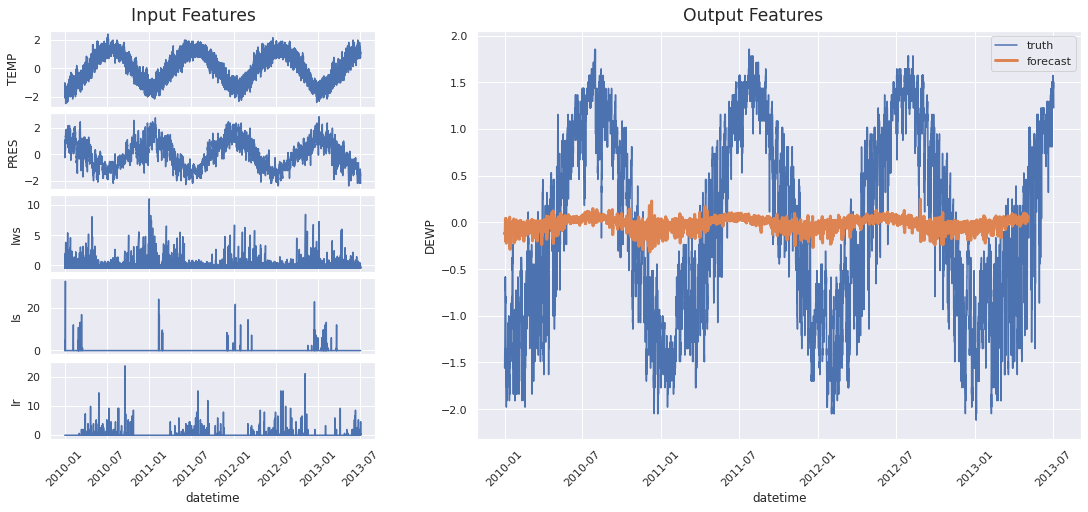

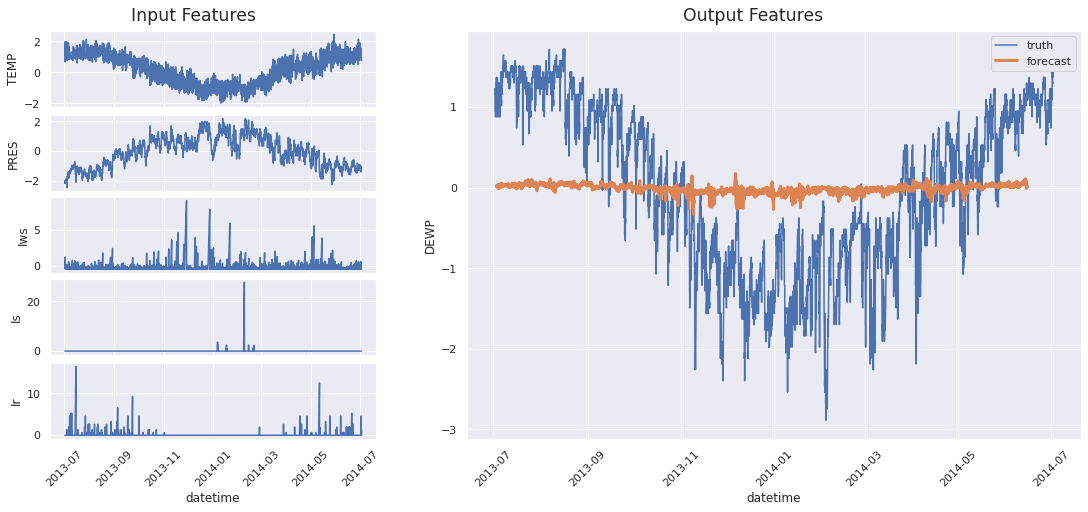

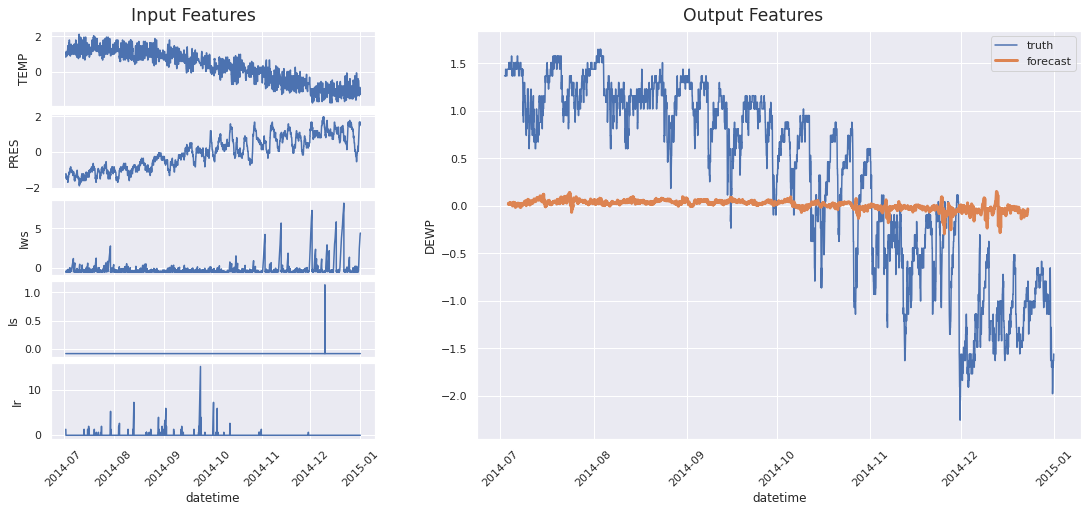

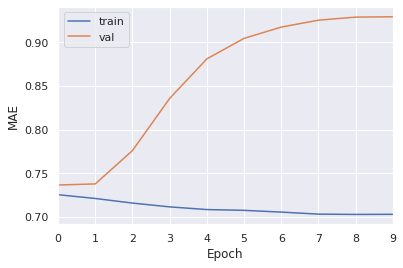

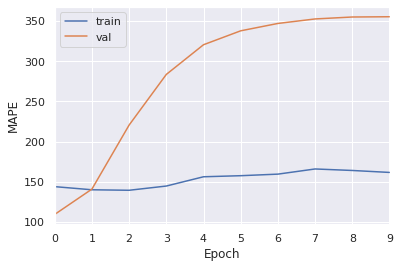

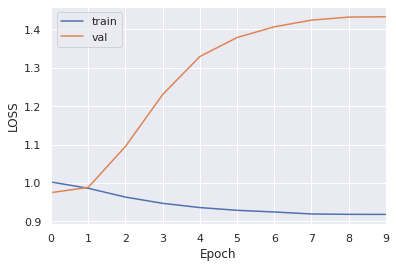

In [550]:
# Define model compilation parameters.
# (i.e., loss, metrics, etc.)
compile_params = dict(
    loss='mse',
    metrics=['mae', 'mape'],
)
# Model hyperparameters.
hparams = dict(
    fc_units=[64,64],
    embed_dim=4,
    n_heads=8,
    ff_dim=2048,
    dropout=0.1,
    n_encoders=3,
    optim='adam',
    lr=lr_schedule,
)

# Build the resulting table header.
table_header = ['model']
for m in ['loss']+compile_params['metrics']:
    table_header.append(f"{m}")
    table_header.append(f"val_{m}")
    table_header.append(f"test_{m}")
table_header.extend(list(hparams))

# Create model building function.
builder = build_model_from_hparams(build_transformer_encoder_net)

# Train and evaluate the model.
# model, hist, met, params, df = train_evaluate_for_dataset(
_ = train_evaluate_for_dataset(
    model_name='transformer',
    build_model_func=builder,
    params=hparams,
    compile_params=compile_params,
    in_seq_len=in_seq_len,
    out_seq_len=out_seq_len,
    shift=shift,
    split=split,
    in_feat=in_feat,
    out_feat=out_feat,
    batch_size=batch_size,
    shuffle=shuffle,
    strategy=strategy,
    epochs=epochs,
    table_header=table_header,
    table_omit_cols=['optim', 'dropout', 'embed_dim', 'mape', 'val_mape', 'test_mape'],
)

#### Tuned Transformer: 0

[transformer_tuned_0] Evaluating 48 hyperparameter combinations
[transformer_tuned_0, model_0] Parameters: {'dropout': 0.1, 'embed_dim': 4, 'fc_units': [64, 64], 'ff_dim': 2048, 'lr': 0.0001, 'n_encoders': 3, 'n_heads': 8, 'optim': 'adam'}
[transformer_tuned_0, model_0] Loading from save data
[transformer_tuned_0, model_0] metrics: {'mae': 0.5751316547393799, 'val_mae': 1.0298855304718018, 'test_mae': 1.0975979566574097, 'mape': 238.84535217285156, 'val_mape': 503.06988525390625, 'test_mape': 558.7532958984375, 'loss': 0.6566843390464783, 'val_loss': 1.8496602773666382, 'test_loss': 1.8511565923690796}
[transformer_tuned_0, model_1] Parameters: {'dropout': 0.1, 'embed_dim': 4, 'fc_units': [64, 64], 'ff_dim': 2048, 'lr': 0.0001, 'n_encoders': 3, 'n_heads': 12, 'optim': 'adam'}
[transformer_tuned_0, model_1] Loading from save data
[transformer_tuned_0, model_1] metrics: {'mae': 0.5800819396972656, 'val_mae': 0.791965126991272, 'test_mae': 0.7775090932846069, 'mape': 236.06448364257812, '

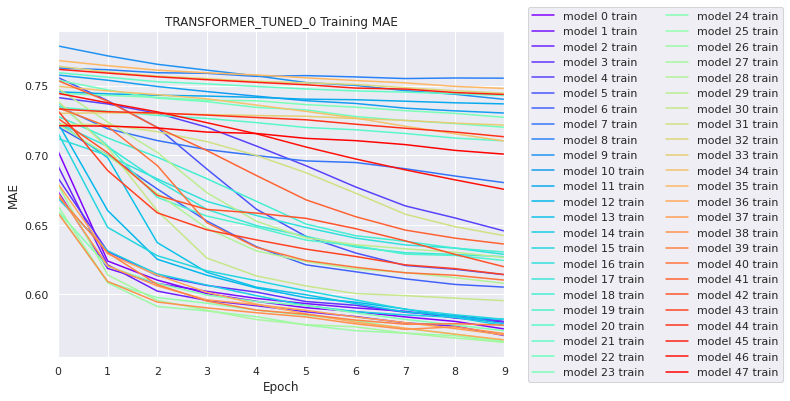

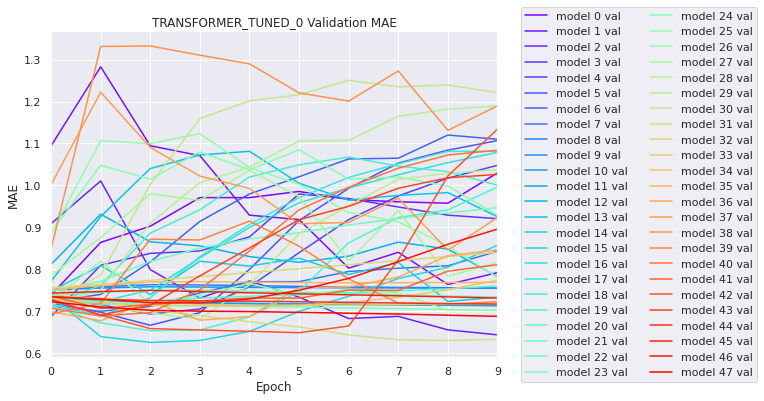

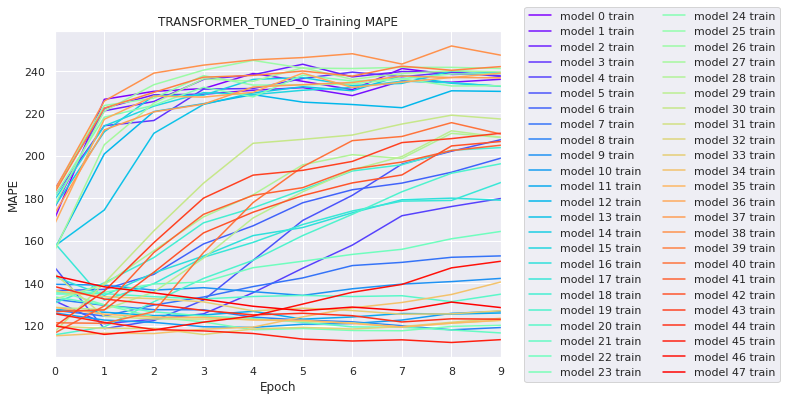

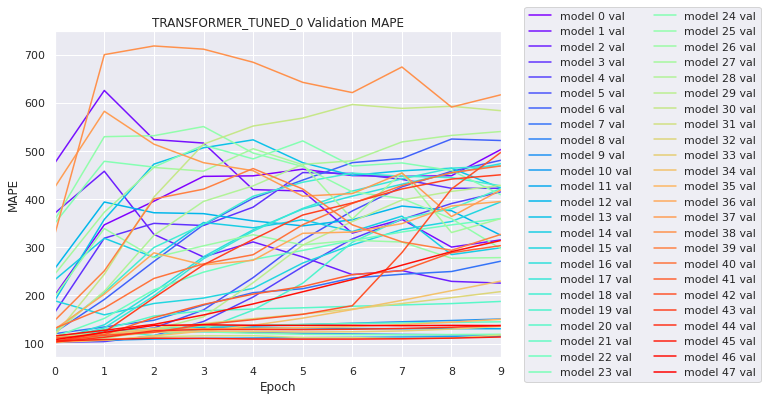

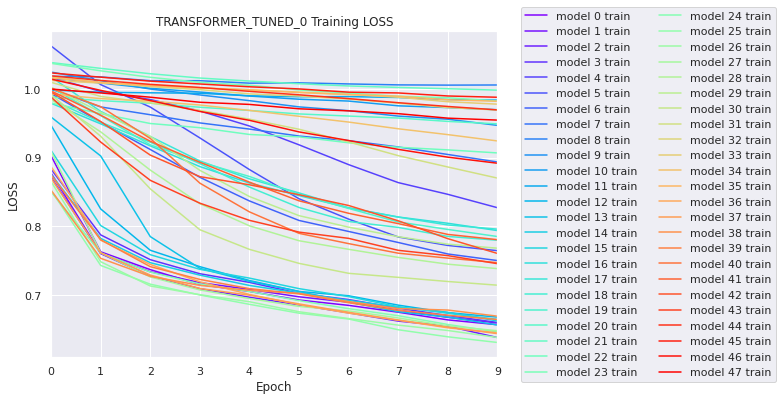

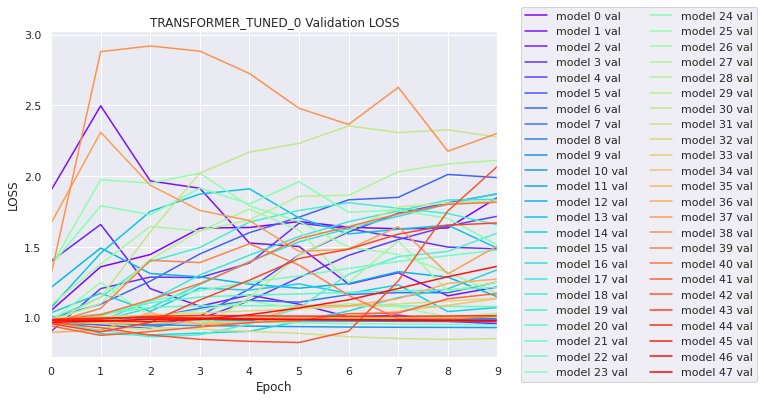

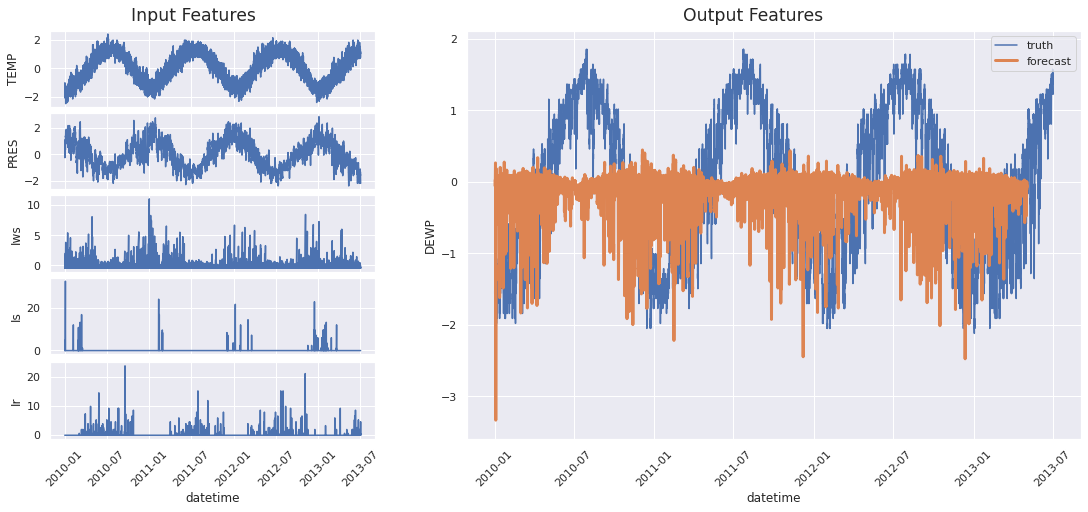

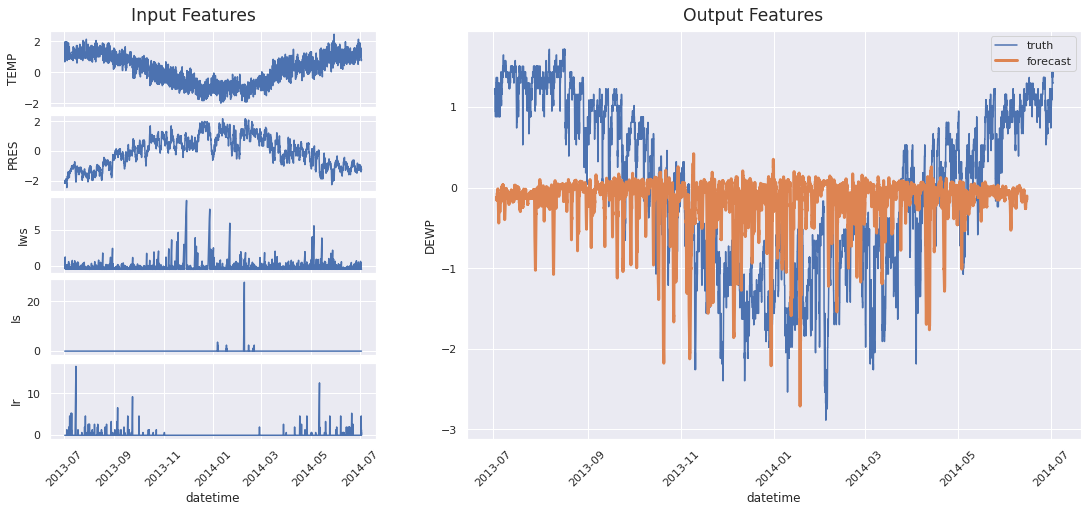

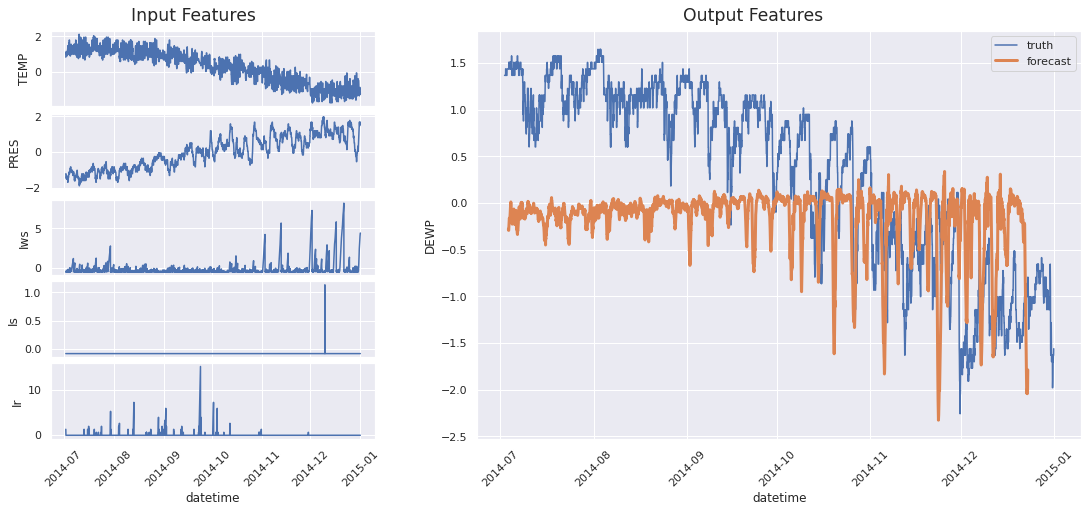

In [557]:
hparams = dict(
    fc_units=[
        [64,64],
        [128,128],
    ],
    embed_dim=[4],
    n_heads=[8, 12],
    ff_dim=[
        2048,
        4096,
    ],
    dropout=[0.1],
    n_encoders=[3, 6],
    optim=['adam'],
    lr=[1e-4, 1e-5, 1e-6],
)

# Define model compilation parameters.
# (i.e., loss, metrics, etc.)
compile_params = dict(
    loss='mse',
    metrics=['mae', 'mape'],
)

# Create model building function.
builder = build_model_from_hparams(build_transformer_encoder_net)

# Build the resulting table header.
table_header = ['model']
for m in ['loss']+compile_params['metrics']:
    table_header.append(f"{m}")
    table_header.append(f"val_{m}")
    table_header.append(f"test_{m}")
table_header.extend(list(hparams))

# Tuning.
_ = hp_gridsearch(
    model_name='transformer_tuned_0',
    build_model_func=builder,
    params=hparams,
    compile_params=compile_params,
    in_seq_len=in_seq_len,
    out_seq_len=out_seq_len,
    shift=shift,
    split=split,
    in_feat=in_feat,
    out_feat=out_feat,
    batch_size=batch_size,
    shuffle=shuffle,
    strategy=strategy,
    epochs=epochs,
    table_header=table_header,
    sort_cols="val_loss",
    table_omit_cols=['optim', 'dropout', 'embed_dim', 'mape', 'val_mape', 'test_mape'],
)

## LSTM

In [551]:
def build_lstm_net(
    in_seq_len: int,
    in_feat: int,
    out_feat: int,
    lstm_units: list[int], # list of LSTM dimensions.
    fc_units: list[int], # list of fully-connected dimensions.
    dropout: float = 0.0,
    ):
    inp = keras.Input(shape=(in_seq_len, in_feat))

    # Build LSTM layers.
    x = inp
    for units in lstm_units:
        x = keras.layers.LSTM(units=units, return_sequences=True)(x)

    # Build fully-connected layers.
    for units in fc_units:
        x = keras.layers.Dense(units=units, activation='relu')(x)
        x = keras.layers.Dropout(rate=dropout)(x)

    # Classifier.
    x = keras.layers.Dense(units=out_feat, activation='linear')(x)

    # Construct model class and return.
    return keras.Model(inputs=inp, outputs=x)

In [552]:
# Create model building function.
builder = build_model_from_hparams(build_lstm_net)

# Define model parameters.
params = dict(
    lstm_units=[128,64],
    fc_units=[64,64],
    dropout=0.1,
    optim='adam',
    lr=1e-3,
)

# Define model compilation parameters.
# (i.e., loss, metrics, etc.)
compile_params = dict(
    loss='mse',
    metrics=['mae', 'mape'],
)

# Build the resulting table header.
table_header = ['model']
for m in ['loss']+compile_params['metrics']:
    table_header.append(f"{m}")
    table_header.append(f"val_{m}")
    table_header.append(f"test_{m}")
table_header.extend(list(params))

# Train and evaluate the model on the desired stock data.
# model, hist, met, params, df = train_evaluate_for_dataset(
_ = train_evaluate_for_dataset(
    model_name='lstm',
    build_model_func=builder,
    params=params,
    compile_params=compile_params,
    in_seq_len=in_seq_len,
    out_seq_len=out_seq_len,
    shift=shift,
    split=split,
    in_feat=in_feat,
    out_feat=out_feat,
    batch_size=batch_size,
    shuffle=shuffle,
    strategy=strategy,
    epochs=epochs,
    table_header=table_header,
    table_omit_cols=['optim', 'dropout', 'embed_dim', 'mape', 'val_mape', 'test_mape'],
)

[lstm] Loading best model from: /home/acd1797/research/makassar/checkpoints/lstm/model.h5


NotImplementedError: Cannot convert a symbolic Tensor (lstm_6/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
df = pd.DataFrame({'a': list(range(10)), 'b':list(range(10))})
df['a'][np.arange(5, 7)]

5    5
6    6
Name: a, dtype: int64